In [207]:
import pandas as pd

df = pd.read_csv('./data/train_df.csv', index_col=0)

train_data = df.loc[df.time < '2018-01-01']
backtest_data = df.loc['2019-01-02':]
stocks = df.code.drop_duplicates()

In [245]:
import talib 


def get_features(data):
    tech_data = pd.DataFrame(index=data.index);

    for t in [2, 3, 4, 5]:
        tech_data[f'SMA_{t}'] = talib.SMA(data.close,timeperiod=t)
        tech_data[f'MOM_{t}'] = talib.MOM(data.close, timeperiod=t)
        tech_data[f'RSI_{t}'] = talib.MOM(data.close, timeperiod=t)
        tech_data[f'MA_{t}'] = talib.MA(data.close, timeperiod=t)
        tech_data[f'DX_{t}'] = talib.DX(data.high, data.low, data.close, timeperiod=t)
#         tech_data[f'volume_change_{t}'] = (data.volume - data.volume.shift(t))/data.volume.shift(t)
#         tech_data[f'volatility_{t}'] = data.close.rolling(t).std()
#         tech_data[f'ADX_{t}'] = talib.ADX(data.high, data.low, data.close, timeperiod=t)
#         tech_data[f'ADXR_{t}'] = talib.ADXR(data.high, data.low, data.close, timeperiod=t)
#         tech_data[f'AROONOSC_{t}'] = talib.AROONOSC(data.high, data.low, timeperiod=t)
#         tech_data[f'ROC_{t}'] = talib.ROC(data.close, timeperiod=t)
        tech_data[f'BIAS_{t}'] = (data['close'] - data['close'].rolling(t, min_periods=1).mean())/ data['close'].rolling(t, min_periods=1).mean()*100
        tech_data[f'BOLL_upper_{t}'], tech_data[f'BOLL_middle_{t}'], tech_data[f'BOLL_lower_{t}'] = talib.BBANDS(
                data.close,
                timeperiod=t,
                nbdevup=2,
                nbdevdn=2,
                matype=0)

    tech_data['SAR'] = talib.SAR(data.high, data.low)
    tech_data['AD'] = talib.AD(data.high, data.low, data.close, data.volume)
    tech_data['OBV'] = talib.OBV(data.close, data.volume)
        
    tech_data['target'] = data.close.pct_change().shift(-1).apply(lambda x: 1 if x > 0 else -1).fillna(0)
    tech_data['time'] = data.time
    tech_data = tech_data.set_index('time')
    
    features = list(set(tech_data.columns) - set(data.columns) - set(['target'])) 
    return tech_data.dropna(), features


data_sets = pd.DataFrame()

for i in stocks:
    etf_data, features= get_features(train_data[train_data.code == i])
    data_sets = pd.concat([data_sets, etf_data])

data_sets = data_sets.dropna()
data_sets = data_sets.sort_values('time')
data_sets.head(5)

,SMA_2,MOM_2,RSI_2,MA_2,DX_2,BIAS_2,BOLL_upper_2,BOLL_middle_2,BOLL_lower_2,SMA_3,...,MA_5,DX_5,BIAS_5,BOLL_upper_5,BOLL_middle_5,BOLL_lower_5,SAR,AD,OBV,target
time,,,,,,,,,,,,,,,,,,,,,
2014-01-09,2.3100,-0.016,-0.016,2.3100,35.446686,-0.303030,2.3240,2.3100,2.2960,2.313000,...,2.3264,74.717833,-1.005846,2.376386,2.3264,2.276414,2.390722,-6.202955e+08,-1.110236e+09,-1
2014-01-09,1.0165,0.009,0.009,1.0165,43.589744,-0.245942,1.0215,1.0165,1.0115,1.012667,...,1.0116,39.759036,0.237248,1.022885,1.0116,1.000315,1.033676,-1.604830e+06,-1.940513e+06,-1
2014-01-09,0.9475,-0.007,-0.007,0.9475,59.235669,-0.474934,0.9565,0.9475,0.9385,0.948333,...,0.9536,71.806167,-1.111577,0.975821,0.9536,0.931379,0.982403,-2.051112e+06,-1.880866e+06,-1
2014-01-09,1.3615,0.024,0.024,1.3615,88.041854,-0.991553,1.3885,1.3615,1.3345,1.349000,...,1.3342,74.634146,1.034328,1.385447,1.3342,1.282953,1.280545,3.126969e+08,3.664487e+08,-1
2014-01-09,1.0260,0.001,0.001,1.0260,43.209877,-0.194932,1.0300,1.0260,1.0220,1.025000,...,1.0250,14.285714,-0.097561,1.040543,1.0250,1.009457,1.041334,4.021272e+06,7.907262e+06,-1


from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, LassoCV
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import numpy as np


X = data_sets[features]
y = data_sets['target']


X_train, X_test = np.split(X, [int(.67 *len(X))])
y_train, y_test = np.split(y, [int(.67 *len(y))])

X_train

### 相关性

In [251]:
selector = RFE(estimator=LogisticRegression(), n_features_to_select=10, step=1)
selector = selector.fit(X, y)
ranking = selector.ranking_.reshape(X.shape)
plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of pixels with RFE")
plt.show()

TypeError: cannot do label indexing on <class 'pandas.core.indexes.base.Index'> with these indexers [0] of <class 'int'>

In [222]:
svm_parameters = {
    'classification__n_estimators':(115, 120, 140, 160)
}
pipline = Pipeline([    
    ('preprocessing', StandardScaler()),
#     ('feature_selection', SelectFromModel(LogisticRegression())),
    ('classification', AdaBoostClassifier())
])

svm = GridSearchCV(pipline, svm_parameters, cv=3)


svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

print('参数:', svm.best_params_)
print('R方值:', accuracy_score(y_test, svm_pred))
print('Report:', classification_report(y_test, svm_pred))

ValueError: Input contains infinity or a value too large for dtype('float64').

In [ ]:
import datetime
import backtrader as bt
import backtrader.feeds as btfeed



class MLStrategy(bt.Strategy):
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.times = 0
        
    def next(self):
        today = self.datas[0].datetime.date(0).isoformat()
        pred_data, factors = get_features(df.loc[df.time <= today])
        pred_data_x = pred_data[factors]
        pred_signal = svm.predict(pred_data_x)
        today_signal = pred_signal[-1] 
        if today_signal > 0:
            self.order_target_percent(target=1)
        else:
            self.close()
            
#         self.times += 1
#         if self.times % 30 == 0:
#             today = self.datas[0].datetime.date(0).isoformat()
#             pred_data, factors = get_features(df.loc[df.time <= today])
#             pred_data = pred_data.dropna()
#             print('fit model again')


Starting Portfolio Value: 100000.00
Final Portfolio Value: 99524.73


<IPython.core.display.Javascript object>


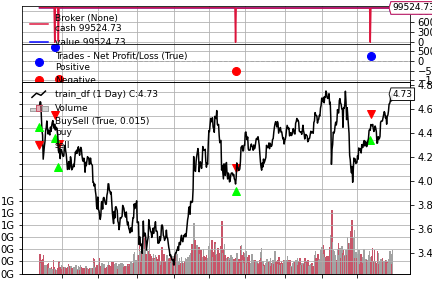

[[<Figure size 432x288 with 4 Axes>]]

In [201]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(MLStrategy)


# Create a Data Feed
data = bt.feeds.GenericCSVData(
        dataname='data/train_df.csv',
        dtformat='%Y-%m-%d',
        fromdate=datetime.datetime(2018, 2, 1),
        todate=datetime.datetime(2020, 7, 1),
        datetime=1,
        high=5,
        low=6,
        open=3,
        close=4,
        volume=7,
        reverse=True)

cerebro.adddata(data)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.broker.setcash(100000.0)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
%matplotlib inline

cerebro.plot()

In [ ]:
import pyfolio as pf

pf.create_returns_tear_sheet(
    returns=returns,
    positions=positions,
    live_start_date='2019-01-01',
    transactions=transactions)

In [ ]:
rdf_parameters = {
    'classification__n_estimators':(140, 150, 160, 170, 180), 
    'classification__max_depth':[4, 5, 6, 7]
}

pipline = Pipeline([    
    ('feature_selection', SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear'))),
    ('classification', RandomForestClassifier())
])

rdf = GridSearchCV(pipline, rdf_parameters, cv=5)


rdf.fit(X_train, y_train)
rdf_pred = rdf.predict(X_test)
print('参数:', rdf.best_params_)
print('准确率:', accuracy_score(y_test, rdf_pred))
print('分类报告:', classification_report(y_test, rdf_pred))

[sudo] password for jovyan: 
